# Data Processing

In [1]:
path_train = u"../src/data/processed/train.730000.csv"
path_val = u"../src/data/processed/val.csv"
path_test = u"../src/data/processed/test.csv"

Reading in word vectors. Reduced to 500k due to RAM limits.

**Todo:** Filter for those vocabularies that are actually in the whole data set.

In [1]:
%%time
import gensim
import numpy as np
embedding_model = gensim.models.KeyedVectors.load_word2vec_format('../src/data/embeddings/GoogleNews-vectors-negative300.bin', binary=True, limit=500_000)
embedding_model.add('<oov>', np.mean(embedding_model.vectors, axis=0),replace=False)
embedding_model.add('<padding>', np.zeros(300),replace=False)

CPU times: user 15.7 s, sys: 2.23 s, total: 17.9 s
Wall time: 17.6 s


In [2]:
embedding_model.__dict__

{'vectors': array([[ 1.12915039e-03, -8.96453857e-04,  3.18527222e-04, ...,
         -1.56402588e-03, -1.23023987e-04, -8.63075256e-05],
        [ 7.03125000e-02,  8.69140625e-02,  8.78906250e-02, ...,
         -4.76074219e-02,  1.44653320e-02, -6.25000000e-02],
        [-1.17797852e-02, -4.73632812e-02,  4.46777344e-02, ...,
          7.12890625e-02, -3.49121094e-02,  2.41699219e-02],
        ...,
        [-1.39648438e-01, -7.65991211e-03,  2.20703125e-01, ...,
         -1.95312500e-01,  3.12500000e-02,  2.44140625e-01],
        [ 1.68127045e-02, -7.47830607e-03, -3.04384865e-02, ...,
         -4.12005782e-02,  1.00802742e-01,  4.45754118e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 'vocab': {'</s>': <gensim.models.keyedvectors.Vocab at 0x7fbe154a9128>,
  'in': <gensim.models.keyedvectors.Vocab at 0x7fbe154a93c8>,
  'for': <gensim.models.keyedvectors.Vocab at 0x7fbe154a9438>,
  'that': <gensim.mo

Create a Dataset for the Amazon reviews.

In [3]:
from torch.utils.data import Dataset
import spacy
import pandas as pd
import numpy as np
import torch

class AmazonReviewDataset(Dataset):
    def __init__(self, path, padding=200, padding_token="<padding>", oov_token="<oov>"):
        
        tokenizer = spacy.load("en_core_web_sm")
        
        self.samples = []
        
        # Load all the data
        data = pd.read_csv(path)
                
        # Tokenize, pad and vectorize each review
        for index, row in data.iterrows():
            
            # Tokenize
            sentence = [token.text for token in tokenizer(row["review"])]
            
            # Pad
            sentence = sentence[:padding] + [padding_token]*(padding - len(sentence))
            
            # Vectorize
            row = [row["id"], row["label"], row["alpha"]] + sentence
            tensor = self.__row2tensor__(row, oov_token)
            
            self.samples.append(tensor)
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        
        return self.samples[idx]
    
    @staticmethod
    def __row2tensor__(sentence, oov_token):
        filled_sentence = [word if embedding_model.vocab.get(word) is not None else oov_token for word in sentence[3:]]
        sentence_as_int = [embedding_model.vocab.get(word).index for word in filled_sentence]
        # X, Y
        return sentence_as_int, sentence[1]

In [4]:
%%time
from os import path
import pickle

pickle_path_train = "data.train-0_20_500k.pickle"

if path.exists(pickle_path_train):
    print("Loading Training Dataset")
    with open(pickle_path_train, "rb") as pickled:
        train_data = pickle.load(pickled)
else:
    print("Creating and saving Training Dataset")
    train_data = AmazonReviewDataset(path_train)
    with open(pickle_path_train, "wb") as pickled:
         pickle.dump(train_data, pickled)

Loading Training Dataset
CPU times: user 8.02 s, sys: 1.65 s, total: 9.68 s
Wall time: 9.68 s


In [5]:
%%time
from os import path
import pickle

pickle_path_val = "data.val-0_10_500k.pickle"

if path.exists(pickle_path_val):
    print("Loading Validation Dataset")
    with open(pickle_path_val, "rb") as pickled:
        val_data = pickle.load(pickled)
else:
    print("Creating and saving Validation Dataset")
    val_data = AmazonReviewDataset(path_val)
    with open(pickle_path_val, "wb") as pickled:
         pickle.dump(val_data, pickled)

Loading Validation Dataset
CPU times: user 5.56 s, sys: 849 ms, total: 6.41 s
Wall time: 6.4 s


In [6]:
#%%time
#from os import path
#import pickle
#
#pickle_path_test = "data.test-0_05_500k.pickle"
#
#if path.exists(pickle_path_test):
#    print("Loading Test Dataset")
#    with open(pickle_path_test, "rb") as pickled:
#        test_data = pickle.load(pickled)
#else:
#    print("Creating and saving Test Dataset")
#    test_data = AmazonReviewDataset(path_test)
#    with open(pickle_path_test, "wb") as pickled:
#         pickle.dump(test_data, pickled)

In [7]:
#%%time
#train_data = AmazonReviewDataset(path_train)

In [8]:
#%%time
#val_data = AmazonReviewDataset(path_val)

Create a DataLoader as well, using a custom collate function for creating the batches.

In [9]:
def batch2tensor(batch):
    X, Y = [None]*len(batch), [None]*len(batch)
    
    for i, row in enumerate(batch):
        X[i] = row[0]
        Y[i] = row[1]
        
    return torch.LongTensor(X), torch.LongTensor(Y)

In [10]:
%%time
from torch.utils.data import DataLoader
dataloader_train = DataLoader(train_data, batch_size=1024, shuffle=True, num_workers=4, collate_fn=batch2tensor)
dataloader_val = DataLoader(val_data, batch_size=1024, shuffle=True, num_workers=4, collate_fn=batch2tensor)

CPU times: user 59 µs, sys: 7 µs, total: 66 µs
Wall time: 70.1 µs


Load one example.

In [11]:
%%time
dataiter_train = iter(dataloader_train)

CPU times: user 213 ms, sys: 324 ms, total: 536 ms
Wall time: 375 ms


In [12]:
%%time
X_dash, Y_dash = dataiter_train.next()

CPU times: user 34.9 ms, sys: 3.29 ms, total: 38.2 ms
Wall time: 11.4 ms


In [13]:
X_dash.shape

torch.Size([1024, 200])

In [14]:
X_dash = X_dash.cuda()
Y_dash = Y_dash.cuda()

In [15]:
X_dash.shape

torch.Size([1024, 200])

In [16]:
Y_dash.shape

torch.Size([1024])

Definition of the network.

In [17]:
import torch.nn as nn

In [18]:
class FFN(nn.Module):
    def __init__(self, word_embeddings, embedding_size=300, padding=200, category_amount=5, dropout=0.25):
        super().__init__()
        
        # Predefined word embeddings
        self.embedding = nn.Embedding.from_pretrained(word_embeddings)
        
        # Dropout
        self.dropout = nn.Dropout(p=dropout)
        
        self.l1 = nn.Linear(embedding_size * padding, 256)
        self.l2 = nn.Linear(256, category_amount)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.embedding(x)
        x = x.view(x.shape[0], -1)
        x = self.l1(x)
        x = self.sigmoid(x)
        x = self.dropout(x)
        x = self.l2(x)
        x = self.softmax(x)
        
        return x

In [19]:
model = FFN(torch.FloatTensor(embedding_model.vectors)).cuda()

In [20]:
model

FFN(
  (embedding): Embedding(500002, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (l1): Linear(in_features=60000, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=5, bias=True)
  (sigmoid): Sigmoid()
  (softmax): LogSoftmax()
)

In [21]:
model(X_dash).shape

torch.Size([1024, 5])

In [22]:
model(X_dash)[0].shape

torch.Size([5])

In [23]:
model(X_dash).shape

torch.Size([1024, 5])

In [24]:
Y_dash.shape

torch.Size([1024])

In [25]:
X_dash.shape

torch.Size([1024, 200])

Look at the untrained model.

In [26]:
from matplotlib import pyplot as plt

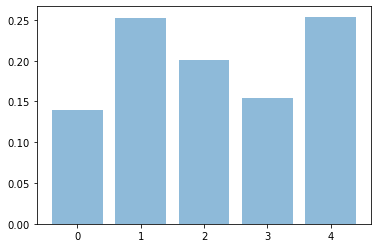

In [27]:
plt.bar(range(0,5), np.exp(model(X_dash).detach().cpu().numpy()[0]), alpha=0.5);

## Training the Model

In [28]:
from torch import optim

In [29]:
#optimizer = optim.SGD(model.parameters(), lr=0.04, nesterov=True, momentum=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.04)

In [30]:
criterion = nn.NLLLoss()

In [31]:
%%time

epochs = 50

train_losses, train_accuracies, validation_losses, validation_accuracies = [], [], [], []

for e in range(epochs):
    
    training_loss = 0
    training_accuracy = 0
    
    for X, Y in dataloader_train:
        X = X.cuda()
        Y = Y.cuda()
    
        # Reset Gradients
        optimizer.zero_grad()
        
        # Forward, Loss, Backwards, Update
        output = model(X)
        loss = criterion(output, Y)
        loss.backward()
        optimizer.step()
        
        # Calculate Metrics
        training_loss += loss.item()
        training_accuracy += torch.sum(torch.exp(output).topk(1)[1].view(-1) == Y).item()
        
    else:
        validation_loss = 0
        validation_accuracy = 0
        
        model.eval()
        
        with torch.no_grad():
            for X, Y in dataloader_val:
                X = X.cuda()
                Y = Y.cuda()  
                
                output_validation = model(X)
                loss_val = criterion(output_validation, Y)
                validation_loss += loss_val.item()
                validation_accuracy += torch.sum(torch.exp(output_validation).topk(1, dim=1)[1].view(-1) == Y).item()
        
        training_loss /= len(train_data)
        training_accuracy /= len(train_data)
        validation_loss /= len(val_data)
        validation_accuracy /= len(val_data)
        
        # Saving metrics
        train_losses.append(training_loss)
        train_accuracies.append(training_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        
        print("Epoch: {}/{}\n".format(e+1, epochs),
              "Training Loss: {:.6f}\n".format(training_loss),
              "Training Accuracy: {:.3f}\n".format(training_accuracy),
              "Validation Loss: {:.6f}\n".format(validation_loss),
              "Validation Accuracy: {:.3f}\n".format(validation_accuracy))
        
        model.train()

Epoch: 1/50
 Training Loss: 0.001580
 Training Accuracy: 0.253
 Validation Loss: 0.001520
 Validation Accuracy: 0.254

Epoch: 2/50
 Training Loss: 0.001510
 Training Accuracy: 0.288
 Validation Loss: 0.001456
 Validation Accuracy: 0.309

Epoch: 3/50
 Training Loss: 0.001475
 Training Accuracy: 0.311
 Validation Loss: 0.001434
 Validation Accuracy: 0.331

Epoch: 4/50
 Training Loss: 0.001446
 Training Accuracy: 0.329
 Validation Loss: 0.001393
 Validation Accuracy: 0.357

Epoch: 5/50
 Training Loss: 0.001432
 Training Accuracy: 0.339
 Validation Loss: 0.001396
 Validation Accuracy: 0.319

Epoch: 6/50
 Training Loss: 0.001419
 Training Accuracy: 0.348
 Validation Loss: 0.001380
 Validation Accuracy: 0.368

Epoch: 7/50
 Training Loss: 0.001409
 Training Accuracy: 0.354
 Validation Loss: 0.001372
 Validation Accuracy: 0.384

Epoch: 8/50
 Training Loss: 0.001400
 Training Accuracy: 0.359
 Validation Loss: 0.001363
 Validation Accuracy: 0.376

Epoch: 9/50
 Training Loss: 0.001395
 Training A

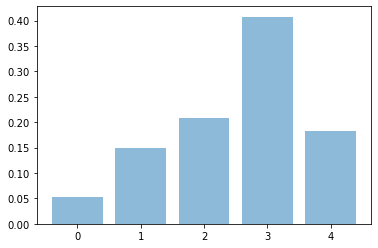

In [32]:
plt.bar(range(0,5), np.exp(model(X_dash).detach().cpu().numpy()[0]), alpha=0.5);

In [33]:
Y_dash[0]

tensor(3, device='cuda:0')

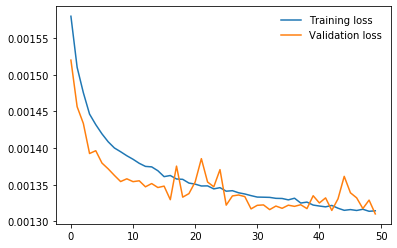

In [34]:
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False);

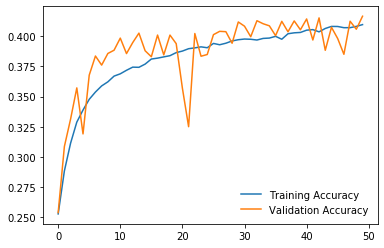

In [35]:
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.legend(frameon=False);

# LSTM

In [17]:
import torch.nn as nn

In [18]:
class LSTM(nn.Module):
    def __init__(self, word_embeddings, embedding_size=300, padding=200,
                 category_amount=5, lstm_layers = 2, lstm_hidden = 128,
                 dropout=0.25, lstm_dropout=0.25):
        
        super().__init__()

        self.lstm_layers = lstm_layers
        self.lstm_hidden = lstm_hidden
        
        # Predefined word embeddings
        self.embedding = nn.Embedding.from_pretrained(word_embeddings)
        
        # LSTM
        self.lstm = nn.LSTM(embedding_size, lstm_hidden, lstm_layers,
                           batch_first=True, dropout=lstm_dropout,
                           bidirectional=False)
        
        # Dropout
        self.dropout = nn.Dropout(p=dropout)
        
        # FFN
        self.l1 = nn.Linear(lstm_hidden * padding, category_amount)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):

        hidden = self.init_hidden(x.shape[0])

        # Pass the input tensor through each of our operations
        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        x = self.dropout(x)
        x = x.reshape(x.shape[0], -1)
        x = self.l1(x)
        x = self.sigmoid(x)
        x = self.softmax(x)
        
        return x#, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes lstm_layers x batch_size x lstm_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_hidden).zero_().cuda(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_hidden).zero_().cuda())
        
        return hidden

In [19]:
import torch

In [20]:
model = LSTM(torch.FloatTensor(embedding_model.vectors)).cuda()

In [21]:
model

LSTM(
  (embedding): Embedding(500002, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (l1): Linear(in_features=25600, out_features=5, bias=True)
  (sigmoid): Sigmoid()
  (softmax): LogSoftmax()
)

In [22]:
#hidden, out = model(X_dash, hidden)
out = model(X_dash)

In [23]:
out.shape

torch.Size([1024, 5])

In [24]:
from torch import optim
optimizer = optim.SGD(model.parameters(), lr=0.05, nesterov=True, momentum=0.1)
#optimizer = optim.SGD(model.parameters(), lr=0.05)

In [25]:
criterion = nn.NLLLoss()

In [26]:
%%time

epochs = 20
clip = 5

train_losses, train_accuracies, validation_losses, validation_accuracies = [], [], [], []

for e in range(epochs):

    # Initialize hidden states
    #hidden = model.init_hidden(1024)
    
    training_loss = 0
    training_accuracy = 0
    
    for X, Y in dataloader_train:
        X = X.cuda()
        Y = Y.cuda()

        #print("Starting batch. {}".format(X.shape))

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        #hidden = tuple([each.data for each in hidden])
    
        # Reset Gradients
        optimizer.zero_grad()
        
        # Forward, Loss, Backwards, Update
        #output, hidden = model(X, hidden)
        output = model(X)
        loss = criterion(output, Y)
        loss.backward()

        # Gradient clipping and update
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        # Calculate Metrics
        training_loss += loss.item()
        training_accuracy += torch.sum(torch.exp(output).topk(1)[1].view(-1) == Y).item()

        #print("Batch done. {}".format(X.shape))
        
    else:
        #print("Validating.")
        # Initialize hidden staes
        model.init_hidden(1024)

        validation_loss = 0
        validation_accuracy = 0
        
        model.eval()
        
        with torch.no_grad():
            for X, Y in dataloader_val:
                X = X.cuda()
                Y = Y.cuda()

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                #val_hidden = tuple([each.data for each in val_hidden])
                
                #output_validation, val_hidden = model(X, val_hidden)
                output_validation = model(X)
                loss_val = criterion(output_validation, Y)
                validation_loss += loss_val.item()
                validation_accuracy += torch.sum(torch.exp(output_validation).topk(1, dim=1)[1].view(-1) == Y).item()
                
        
        training_loss /= len(train_data)
        training_accuracy /= len(train_data)
        validation_loss /= len(val_data)
        validation_accuracy /= len(val_data)
        
        # Saving metrics
        train_losses.append(training_loss)
        train_accuracies.append(training_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        
        print("Epoch: {}/{}\n".format(e+1, epochs),
              "Training Loss: {:.6f}\n".format(training_loss),
              "Training Accuracy: {:.3f}\n".format(training_accuracy),
              "Validation Loss: {:.6f}\n".format(validation_loss),
              "Validation Accuracy: {:.3f}\n".format(validation_accuracy))
        
        model.train()

Epoch: 1/20
 Training Loss: 0.001572
 Training Accuracy: 0.211
 Validation Loss: 0.001573
 Validation Accuracy: 0.238

Epoch: 2/20
 Training Loss: 0.001571
 Training Accuracy: 0.230
 Validation Loss: 0.001572
 Validation Accuracy: 0.243

Epoch: 3/20
 Training Loss: 0.001569
 Training Accuracy: 0.237
 Validation Loss: 0.001570
 Validation Accuracy: 0.240

Epoch: 4/20
 Training Loss: 0.001565
 Training Accuracy: 0.239
 Validation Loss: 0.001564
 Validation Accuracy: 0.241

Epoch: 5/20
 Training Loss: 0.001555
 Training Accuracy: 0.251
 Validation Loss: 0.001545
 Validation Accuracy: 0.268

Epoch: 6/20
 Training Loss: 0.001509
 Training Accuracy: 0.290
 Validation Loss: 0.001471
 Validation Accuracy: 0.319

Epoch: 7/20
 Training Loss: 0.001461
 Training Accuracy: 0.329
 Validation Loss: 0.001444
 Validation Accuracy: 0.345

Epoch: 8/20
 Training Loss: 0.001445
 Training Accuracy: 0.344
 Validation Loss: 0.001442
 Validation Accuracy: 0.349

Epoch: 9/20
 Training Loss: 0.001438
 Training A

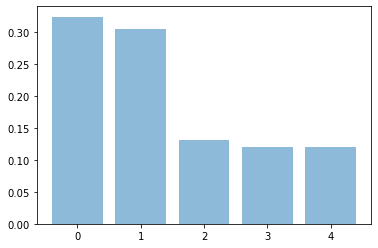

In [27]:
from matplotlib import pyplot as plt
plt.bar(range(0,5), np.exp(model(X_dash).detach().cpu().numpy()[0]), alpha=0.5);

In [28]:
Y_dash[0]

tensor(1, device='cuda:0')

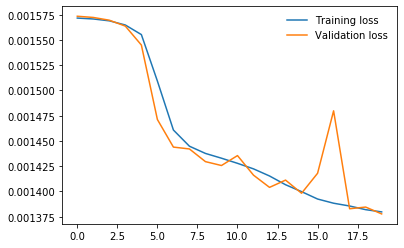

In [29]:
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False);

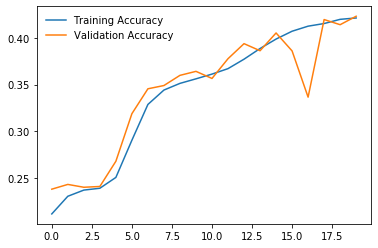

In [30]:
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.legend(frameon=False);

# Old

In [ ]:
import pandas as pd 

In [ ]:
train = pd.read_csv("/home/flennic/git/text-mining-project/src/data/processed/train.csv", header=None)
test = pd.read_csv("/home/flennic/git/text-mining-project/src/data/processed/test.csv", header=None) 

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
import logging
import torch
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

logger = logging.getLogger(__name__)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

In [ ]:
model.config

In [ ]:
model.eval();

In [ ]:
model.to('cuda');

In [ ]:
input_ids1 = torch.tensor(tokenizer.encode("Hello, my dog is cute".lower(), add_special_tokens=True)).unsqueeze(0).to('cuda')  # Batch size 1
input_ids2 = torch.tensor(tokenizer.encode("Hello, my cat is ugly".lower(), add_special_tokens=True)).unsqueeze(0).to('cuda')  # Batch size 1

In [ ]:
input_ids1.shape

In [ ]:
input_ids = torch.cat((input_ids1, input_ids2))

In [ ]:
input_ids.shape

In [ ]:
labels = torch.tensor([0, 1]).unsqueeze(0).to('cuda')   # Batch size 1

In [ ]:
labels

In [ ]:
outputs = model(input_ids, labels=labels)

In [ ]:
outputs

In [ ]:
loss, logits = outputs[:2]

In [ ]:
import numpy as np

In [ ]:
np.exp(logits.detach().cpu().numpy())

In [ ]:
outputs = model(input_ids)

In [ ]:
outputs

## Raw BERT

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
model.config

In [ ]:
model.eval();

In [ ]:
model.to('cuda');

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', output_hidden_states=True)
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0).to('cuda')  # Batch size 1
outputs = model(input_ids)
last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple

In [ ]:
tokenizer.tokenize("Hello, my dog is cute")

In [ ]:
tokenizer.cls_token

In [ ]:
tokenizer.convert_tokens_to_ids("[CLS]")

In [ ]:
input_ids

In [ ]:
outputs[1].shape

In [ ]:
outputs[0].shape

In [ ]:
outputs[0][0, 0,:].shape

In [ ]:
a = ("a", "b", "c")

In [ ]:
b = (1, 2) + a

In [ ]:
b

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
!pwd

In [ ]:
model = KeyedVectors.load_word2vec_format('src/data/embeddings/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
model["hello"].shape